# Calculate sigma of IS2 within 500m ASO grid cells

In [4]:
# import necessary packages

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from astropy.time import Time
import datetime
import pickle
import rasterio as rio
from geoviews import opts, tile_sources as gvts

# Import raster sampling functions written by Friedrich Knuth from UW-Cryo: 
# https://github.com/uw-cryo/raster_sampling/blob/master/friedrich/core.py
import core

In [8]:
!pwd

/Users/Hannah/Documents/Documents_Grad/Research/CorrelatedDomains/notebooks


In [52]:
# Load ATL06-SR data, from icesat2-sr:
atl06sr_gdf = pickle.load(open('../data/icesat2/tuolumne_all_sr-atl06-09282022_processed_bicubic_snowonaso.pkl', 'rb'))

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_5765/3752447394.py:2: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  atl06sr_gdf = pickle.load(open('../data/icesat2/tuolumne_all_sr-atl06-09282022_processed_bicubic_snowonaso.pkl', 'rb'))


### Use only ICESat-2 data that fell within 5m snow depth as compared to ASO snow depth:  
I'm not actually sure whether to do this or not - should I use all the data because we wouldn't know this for other areas where we don't have ASO to compare to?

In [53]:
atl06sr_gdf['zscore'] = (atl06sr_gdf['diff_plus_bicubic'] - atl06sr_gdf['diff_plus_bicubic'].mean()) / atl06sr_gdf['diff_plus_bicubic'].std()

zscore_thresh = 3
absdiff_thresh = 5.0

In [54]:
atl06_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) #& (atl06sr_gdf['diff_plus_bicubic'].abs() <= absdiff_thresh)

inner_snowoff_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus_bicubic'].abs() <= absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 0)

inner_snowon_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus_bicubic'].abs() <= absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 1)

In [55]:
atl06sr_gdf_inner = atl06sr_gdf[atl06_idx]

In [18]:
#atl06sr_gdf['acqdate'] = atl06sr_gdf.index.date

### Try out method for one date pair:  
ICESat-2 date: 4-10-2019  
ASO date: 4-17-2019

In [130]:
is2_date = datetime.date(2019, 4, 10)

atl06sr_date = atl06sr_gdf[atl06sr_gdf['acqdate'] == is2_date]

Next steps:
* downsample the snow-on file to 500m resolution and convert to polygons, using gdal translate in the command line
* Use rasterstats to get the median aso snow-on value within each grid cell polygon
* replace this value in the polygon file, or somehow make this data spatial
* spatial join with the is2 dataframe from the same date

### Upscale the ASO snow-on file to make a 500m resolution grid  
Use gdal in the command line:  
gdalwarp -tr 500 500 -r cubic ASO_3M_SD_USCATE_20190417.tif ../../../../../../CorrelatedDomains/data/lidar/ASO_3M_SD_USCATE_20190417_500m.tif

In [ ]:
# Read in the result of this:
aso_fn = '../data/lidar/ASO_3M_SD_USCATE_20190417_500m.tif'

import rioxarray as rxr
aso_500m = rxr.open_rasterio(aso_fn, masked=True).squeeze()

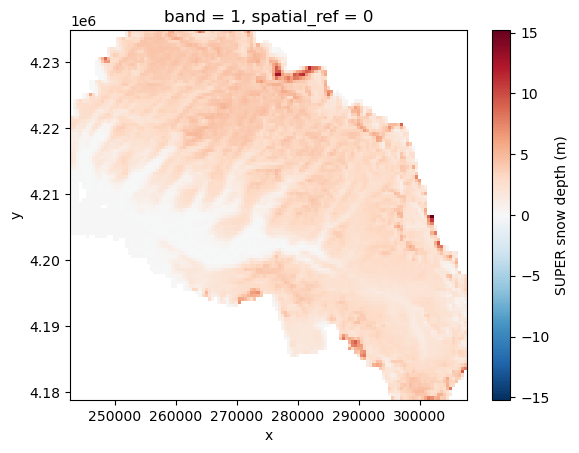

In [25]:
# And visualize:
aso_500m.plot()

### Make a fishnet from the data

In [40]:
# Code adapted from https://spatial-dev.guru/2022/05/22/create-fishnet-grid-using-geopandas-and-shapely/

from shapely import geometry

# Get minX, minY, maxX, maxY
minX, minY, maxX, maxY = aso_500m.rio.bounds()

# Create a fishnet
x, y = (minX, minY)
geom_array = []

# Polygon Size
square_size = 500
while y <= maxY:
    while x <= maxX:
        geom = geometry.Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
        geom_array.append(geom)
        x += square_size
    x = minX
    y += square_size

fishnet = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs('EPSG:32611')
fishnet.to_file('fishnet_grid.shp')

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

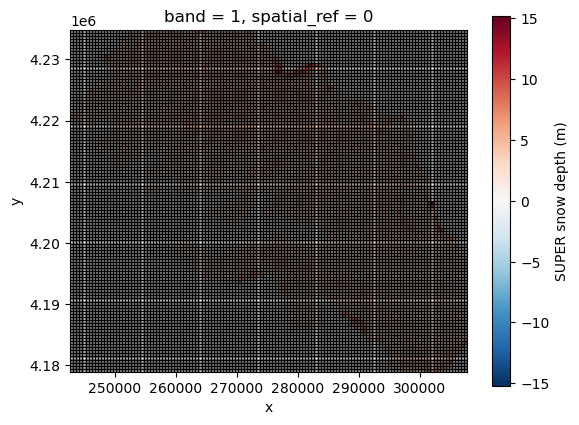

In [44]:
# Plot the fishnet on top of the coarsened ASO data:
fig, ax = plt.subplots()

aso_500m.plot(ax=ax)
fishnet.plot(ax=ax, edgecolor='k', facecolor='none')

(4180000.0, 4185000.0)

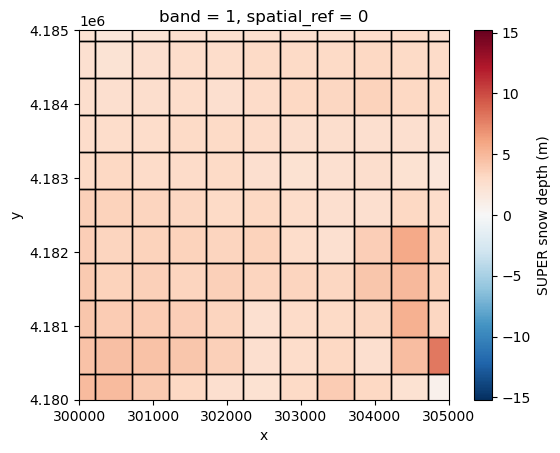

In [51]:
# Zoom in to see if cells and fishnet align:
fig, ax = plt.subplots()

aso_500m.plot(ax=ax)
fishnet.plot(ax=ax, edgecolor='k', facecolor='none')
ax.set_xlim(300000,305000)
ax.set_ylim(4180000,4185000)

In [45]:
fishnet["area"] = fishnet['geometry'].area

<Axes: >

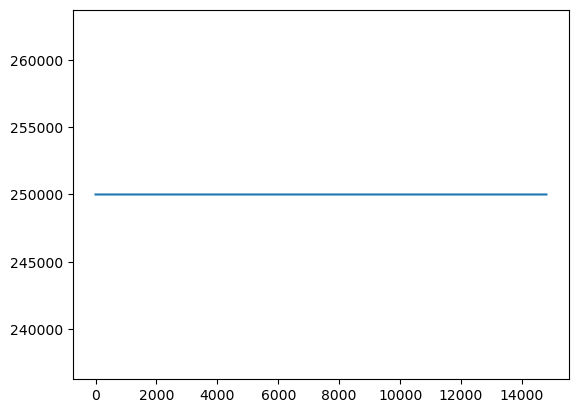

In [47]:
# Make sure all fishnet polygons are the same size:
fishnet['area'].plot()

In [48]:
500 **2

250000

In [50]:
fishnet.head()

,geometry,area
0,"POLYGON ((242715.000 4178848.000, 242715.000 4...",250000.0
1,"POLYGON ((243215.000 4178848.000, 243215.000 4...",250000.0
2,"POLYGON ((243715.000 4178848.000, 243715.000 4...",250000.0
3,"POLYGON ((244215.000 4178848.000, 244215.000 4...",250000.0
4,"POLYGON ((244715.000 4178848.000, 244715.000 4...",250000.0


### Calculate the median ASO snow depth within each fishnet polygon

In [84]:
print(fishnet.loc[0,'geometry'])

POLYGON ((242715 4178848, 242715 4179348, 243215 4179348, 243215 4178848, 242715 4178848))


In [87]:
rasterstats = zonal_stats(fishnet.loc[0,'geometry'], aso_fn, nodata=(-9999.0), 
                          stats="median")

In [93]:
from rasterstats import zonal_stats

fishnet['aso_median'] = np.nan

for i in range(len(fishnet)):
    rasterstats = zonal_stats(fishnet.loc[i,'geometry'], aso_fn, nodata=(-9999.0), 
                          stats="median")
    fishnet.loc[i,'aso_median'] = rasterstats[0]['median']

fishnet['aso_median'] = fishnet['aso_median'].astype('float')

<Axes: >

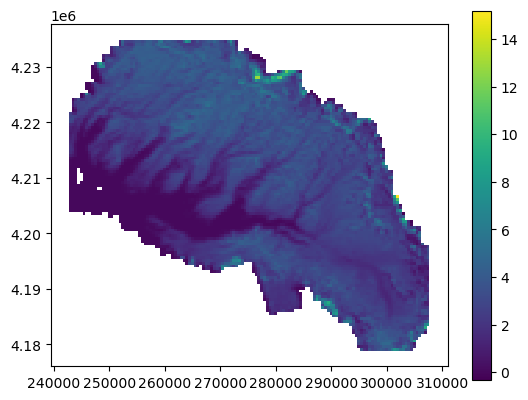

In [110]:
fig, ax = plt.subplots()
fishnet.plot(column = fishnet['aso_median'], legend=True, ax=ax)
#plt.colorbar(label='median ASO snow depth')

In [119]:
fishnet_nan = fishnet.dropna()

### Calculate the median ICESat-2 snow depth value within each 500m grid cell:

In [131]:
pointInPolys = gpd.sjoin(atl06sr_date, fishnet, how='left')

In [115]:
pointInPolys.columns

Index(['distance', 'h_sigma', 'rgt', 'delta_time', 'pflags', 'dh_fit_dy',
       'segment_id', 'w_surface_window_final', 'dh_fit_dx', 'h_mean', 'spot',
       'gt', 'cycle', 'rms_misfit', 'n_fit_photons', 'geometry', 'doy',
       'decyear', 'dowy', 'snow_presence', 'lidar_z', 'difference',
       'bicubic_lidar_z', 'sampling_dif', 'difference_bicubic', 'site',
       'acqdate', 'n', 'diff_plus', 'diff_plus_bicubic', 'zscore',
       'ASO_snowon', 'ASO_snowon_date', 'ASO_snowon_bic', 'median_slope20d',
       'index_right', 'area', 'aso_median'],
      dtype='object')

In [116]:
pointInPolys.index_right

time
2018-10-15 23:22:20.018965444    4638
2018-10-15 23:22:20.021811344    4638
2018-10-15 23:22:20.027481712    4638
2018-10-15 23:22:20.030305900    4638
2018-10-15 23:22:20.033126928    4638
                                 ... 
2022-06-06 07:52:14.166292256    5876
2022-06-06 07:52:14.174719728    5876
2022-06-06 07:52:14.177525200    5876
2022-06-06 07:52:14.183137424    5876
2022-06-06 07:52:14.185946192    5876
Name: index_right, Length: 151976, dtype: int64

In [132]:
fishnet_nan['is2_median'] = pointInPolys.groupby('index_right')['diff_plus_bicubic'].median()

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

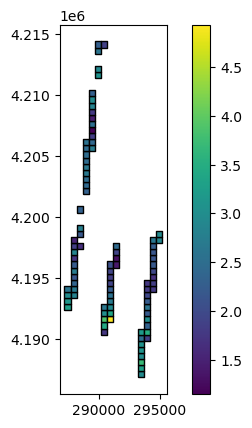

In [142]:
fishnet_nan.plot(column = 'is2_median', edgecolor='k', legend=True)

In [134]:
fishnet_nan['aso_is2_dif'] = fishnet_nan['aso_median'] - fishnet_nan['is2_median']

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

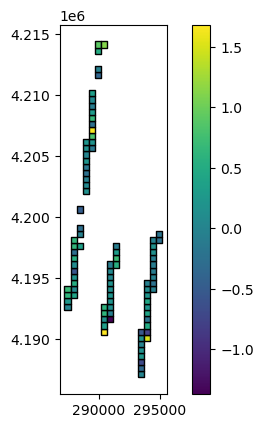

In [141]:
fishnet_nan.plot(column = 'aso_is2_dif', edgecolor='k',legend=True)

<Axes: >

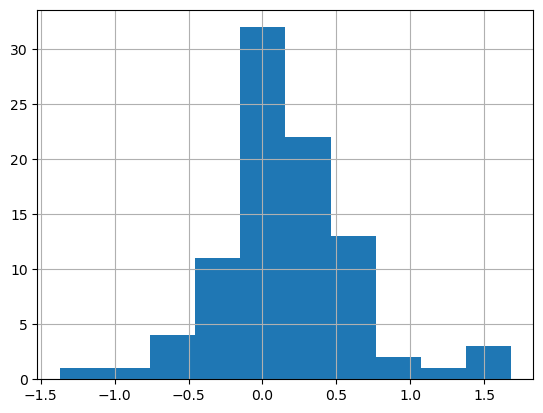

In [139]:
fishnet_nan['aso_is2_dif'].hist()

In [140]:
fishnet_nan['aso_is2_dif'].describe()

count    90.000000
mean      0.155507
std       0.465896
min      -1.370383
25%      -0.086503
50%       0.127334
75%       0.344817
max       1.681832
Name: aso_is2_dif, dtype: float64

### Scale up to iterate these methods over all 8 pairs:

### OLD: Make this grid into polygons so I can do a spatial join of IS2 points within each grid polygon  
Use gdal in the command line:  
gdal_polygonize.py ASO_3M_SD_USCATE_20190417_500m.tif grid_polys.shp

In [26]:
# Read in the result of this:
aso_grid = '../data/lidar/grid_polys.shp'
grid = gpd.read_file(aso_grid)

<Axes: >

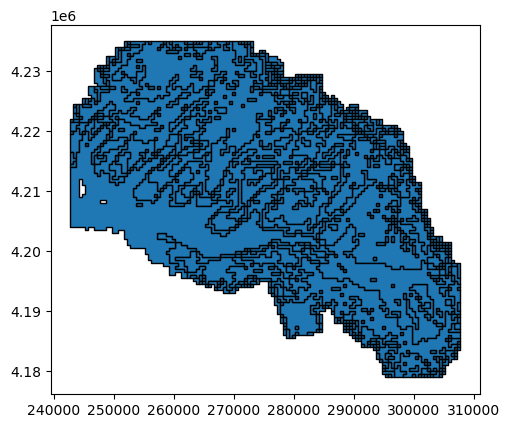

In [31]:
# And visualize:
grid.plot(edgecolor='k')

In [30]:
grid.head()

,DN,geometry
0,1,"POLYGON ((251715.000 4234848.000, 252215.000 4..."
1,5,"POLYGON ((252215.000 4234848.000, 252715.000 4..."
2,3,"POLYGON ((255715.000 4234848.000, 256215.000 4..."
3,3,"POLYGON ((258215.000 4234848.000, 258715.000 4..."
4,5,"POLYGON ((258715.000 4234848.000, 259215.000 4..."
